In [68]:
import pandas as pd
import joblib
import pm4py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = joblib.load("../../data/processed/data_clean.pkl")
data["key"] = data["id"].astype(str) + "-" + data["sessionId"].astype(str)

In [98]:
data["event"].unique()

array(['LOAD_NEW_PAGE_PRODUCT', 'LOAD_NEW_PAGE_HOME', 'VIDEO_START',
       'VIDEO_PROGRESS', 'FILTER_BY', 'CLICK', 'DETAILS_VIEW',
       'LOAD_NEW_PAGE_SHOWROOM', 'LOAD_NEW_PAGE_SEARCH',
       'LOAD_NEW_PAGE_NEWS', 'LOAD_NEW_PAGE_PROMOTION',
       'LOAD_NEW_PAGE_SERVICE', 'LOAD_NEW_PAGE_LEGAL',
       'LOAD_NEW_PAGE_INFO', 'LOAD_NEW_PAGE_INSPIRATION',
       'VIDEO_COMPLETE', 'DOWNLOAD', 'LOAD_NEW_PAGE_COMPANY',
       'LOAD_NEW_PAGE_ERROR', 'ADD_TO_CART', 'LOAD_NEW_PAGE_CHECKOUT',
       'CHECKOUT', 'LOAD_NEW_PAGE_ACCOUNT', 'PAYMENT',
       'LOAD_NEW_PAGE_JOBS', 'LOAD_NEW_PAGE_COMPARISON',
       'REMOVE_FROM_CART'], dtype=object)

In [77]:
n_cases_min = 1
n_cases_max = 10000

n_seconds_min = 30
n_seconds_max = 200000
channel = ["Organic Search", "Referral"]
device = ["desktop"]
platform = ["Windows", "Android", "iOS", "Macintosh"]
#constant per case 

events_excluded = ["LOAD_NEW_PAGE_JOBS"]
#exclude all cases that have ANY of these events

filter = "and"
events_needed = ["LOAD_NEW_PAGE_PROMOTION"]
#filter all cases that include "either" (="or") or "all" (="and")


In [78]:
filtered_data = pm4py.filter_case_size(data, n_cases_min, n_cases_max, case_id_key="key")

filtered_data = pm4py.filter_case_performance(filtered_data, n_seconds_min, n_seconds_max, 
                                       case_id_key="key", timestamp_key="activityTime")

filtered_data = pm4py.filter_event_attribute_values(filtered_data, attribute_key="channelGrouping", 
                                                    values=channel, level="case", retain=True, 
                                                    case_id_key="key")
filtered_data = pm4py.filter_event_attribute_values(filtered_data, attribute_key="deviceCategory", 
                                                    values=device, level="case", retain=True, 
                                                    case_id_key="key")
filtered_data = pm4py.filter_event_attribute_values(filtered_data, attribute_key="platform", 
                                                    values=platform, level="case", retain=True, 
                                                    case_id_key="key")

if filter == "and":

    for event in events_needed: 
        filtered_data = pm4py.filter_event_attribute_values(filtered_data, attribute_key="event", 
                                                            values=[event], level="case", retain=True, 
                                                            case_id_key="key")
else:
    filtered_data = pm4py.filter_event_attribute_values(filtered_data, attribute_key="event", 
                                                            values=events_needed, level="case", retain=True, 
                                                            case_id_key="key")
    
filtered_data = pm4py.filter_event_attribute_values(filtered_data, attribute_key="event", 
                                                    values=events_excluded, level="case", retain=False, 
                                                    case_id_key="key")

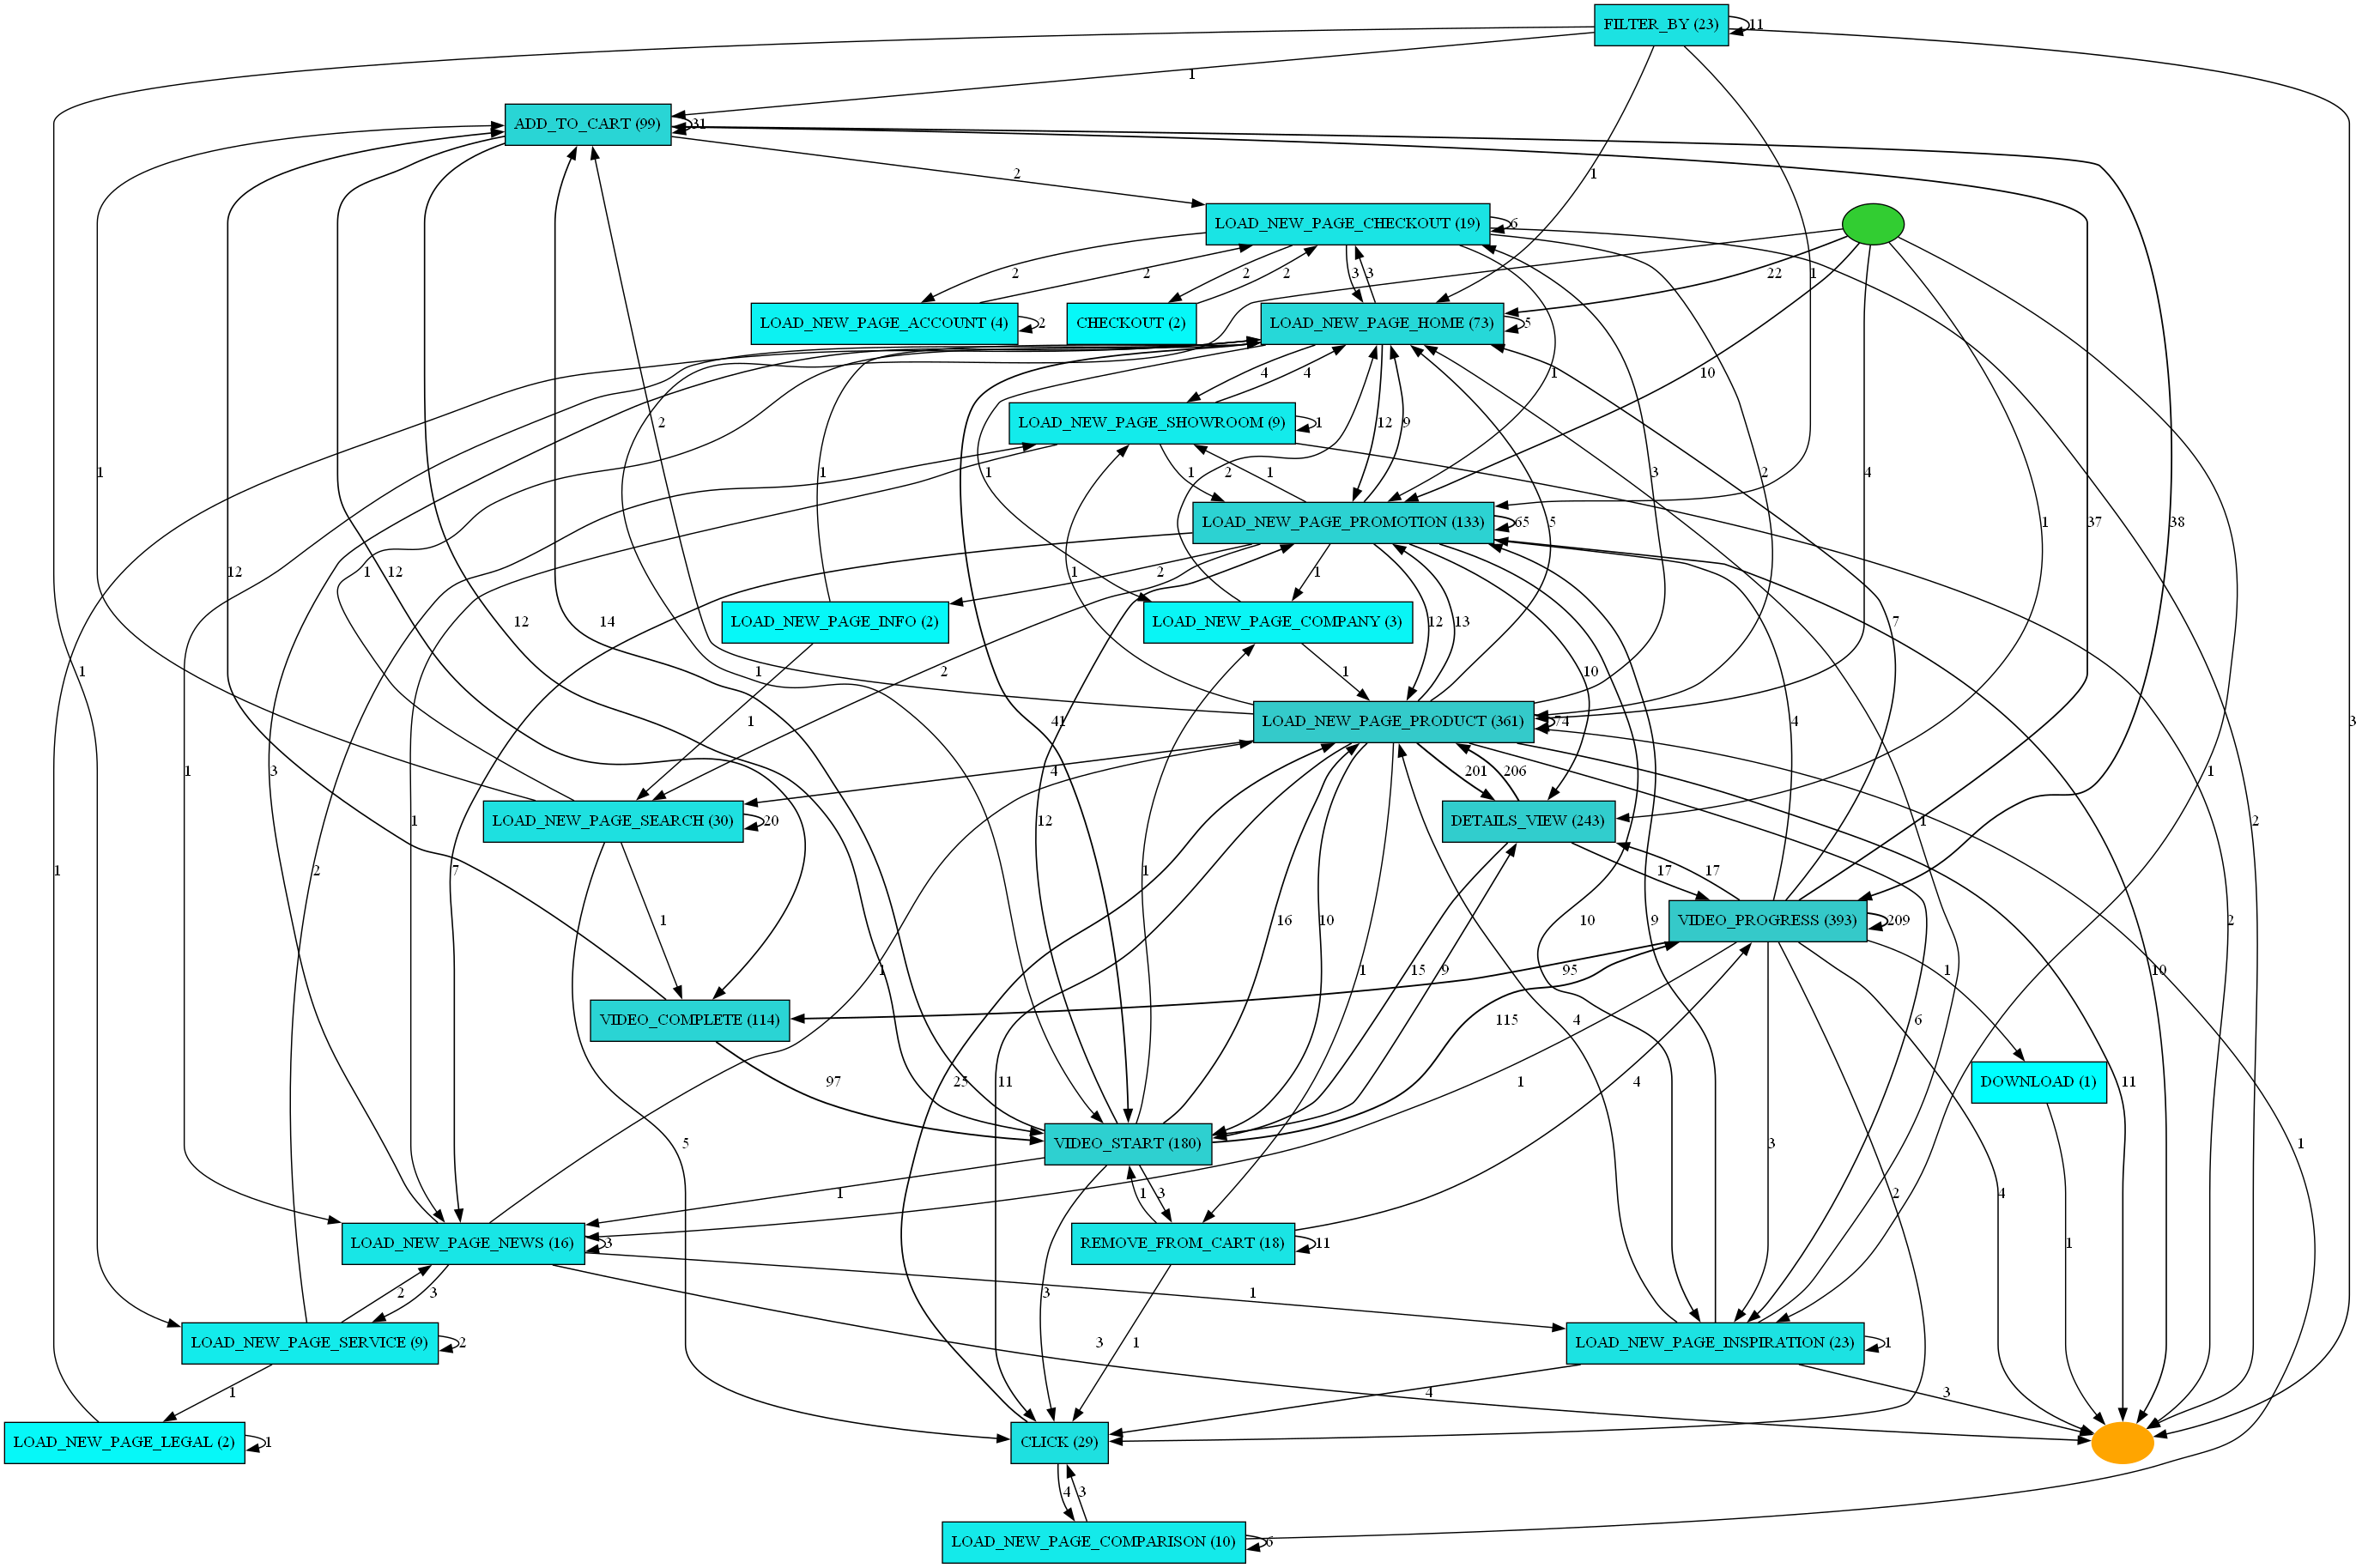

In [99]:
map = pm4py.discover_heuristics_net(filtered_data, activity_key="event", timestamp_key="activityTime", case_id_key="key")
test = pm4py.view_heuristics_net(map)

<Axes: xlabel='Time'>

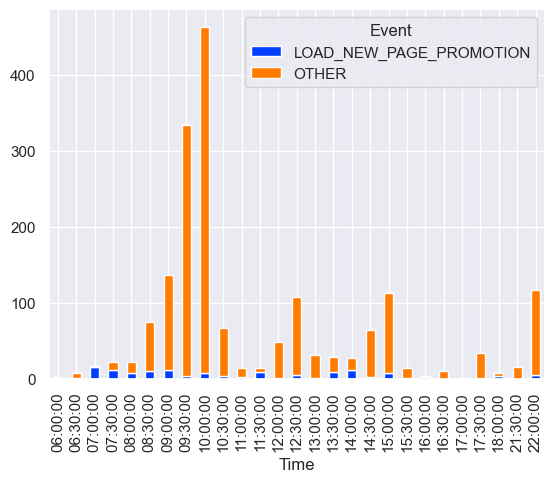

In [107]:
%matplotlib inline
filtered_data["Time"] = filtered_data["activityTime"].dt.round('30T').dt.time
filtered_data["Event"] = np.where(filtered_data["event"].isin(events_needed), filtered_data["event"], "OTHER")

df_plot = filtered_data.groupby(['Event', 'Time']).size().reset_index().pivot(columns='Event', index='Time', values=0)

sns.set_theme(style="darkgrid", palette="bright")
fig, ax = plt.subplots()
df_plot.plot(kind='bar', stacked=True, ax=ax)


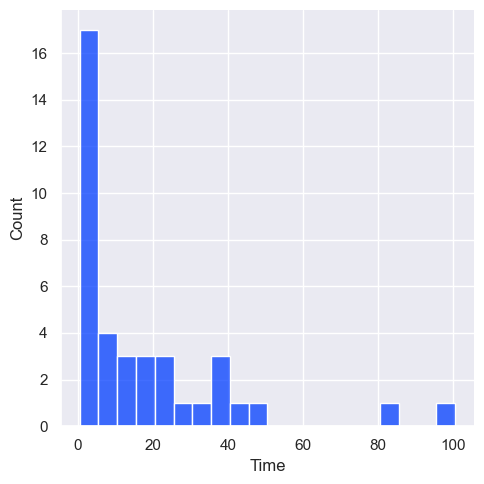

In [94]:
df_plot = filtered_data.groupby(["id", "sessionId"]).apply(lambda x: (x["activityTime"].max() - x["activityTime"].min()).total_seconds()).reset_index()
df_plot.columns = ["id", "sessionId", "n_minutes"]
df_plot["Time"] = (df_plot["n_minutes"]/60)

sns.set_theme(style="darkgrid", palette="bright")
sns.displot(df_plot, x="Time", binwidth=5)

c:\Users\cosemti\.virtualenvs\ALGO-Smeg-tpBFOsly\lib\site-packages\seaborn\distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


TypeError: Invalid object type at position 0

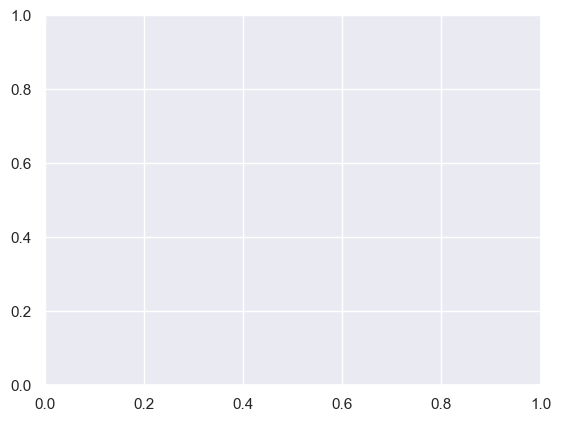

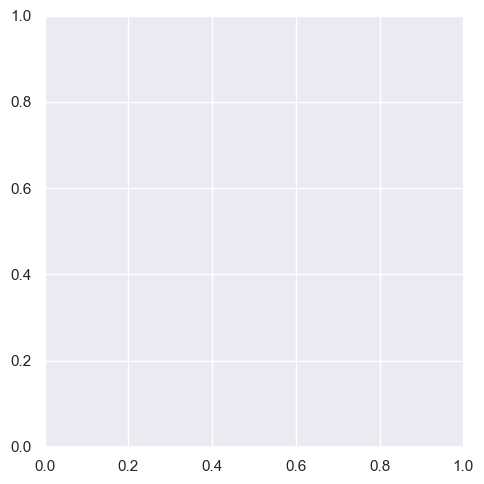

In [109]:
sns.set_theme(style="darkgrid", palette="bright")
fig2, ax2 = plt.subplots()
sns.displot(df_plot, x="Time", binwidth=5, ax=ax2)

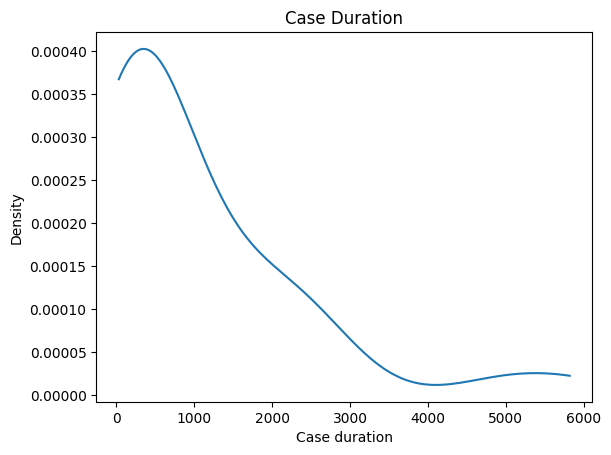

In [90]:
pm4py.view_case_duration_graph(filtered_data, activity_key="event", timestamp_key="activityTime", case_id_key="key")

If there are a lot of skips (X) and then returns, this describes everything is possible. It is very difficult to get meaning out of this. Filters can solve a part of this problem. The frequency threshold can be increased, higher means a more simplified version. This is a parameter that requires tuning from the user side to get a reasonable description of the process.

TO DO: 
- welke visualisatie is het mooiste? 
- descriptieve grafieken van pm4py? 
- dashboard met parameters
- uitleg inductive miner
- vervolgstappen: A/B-testing input of recommender systems (paper)

In [43]:
pm4py.save_vis_bpmn(bpmn_model, "../../reports/figures/bpmn.png")